In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import missingno as msno


In [2]:
sys.path.append("../src")
from garch.utils import calculate_historical_volatility, test_stationarity, fit_model, find_best_order, plot_predictions_vs_actual


In [ ]:
df=pd.read_csv("../data_macro.csv")
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(by="date")

In [4]:
df.head()

,date,eurusd_close,eurusd_open,eurusd_high,eurusd_low,sp500,euro_stoxx_600,dax,SOFR,ester,BEIR_10Y_US,BEIR_10Y_EU,DGS10,DGS3MO,EURO_IR_3MO,EURO_IR_10Y
0,2018-04-03,1.229271,1.229332,1.233700,1.225505,2614.449951,369.070007,12002.450195,1.83,-0.452,2.08,1.518,2.79,1.75,-0.660035,0.552061
1,2018-04-04,1.227853,1.227943,1.231057,1.225761,2644.689941,367.329987,11957.900391,1.74,-0.454,2.08,1.511,2.79,1.71,-0.664585,0.547333
2,2018-04-05,1.228682,1.228788,1.229105,1.221941,2662.840088,376.130005,12305.190430,1.75,-0.453,2.08,1.509,2.83,1.72,-0.659658,0.570174
3,2018-04-06,1.225160,1.225100,1.228003,1.221807,2604.469971,374.820007,12241.269531,1.75,-0.453,2.07,1.510,2.77,1.73,-0.664742,0.559924
4,2018-04-09,1.227144,1.227144,1.233046,1.226257,2613.159912,375.299988,12261.750000,1.75,-0.453,2.07,1.508,2.78,1.76,-0.657340,0.561172


<Axes: >

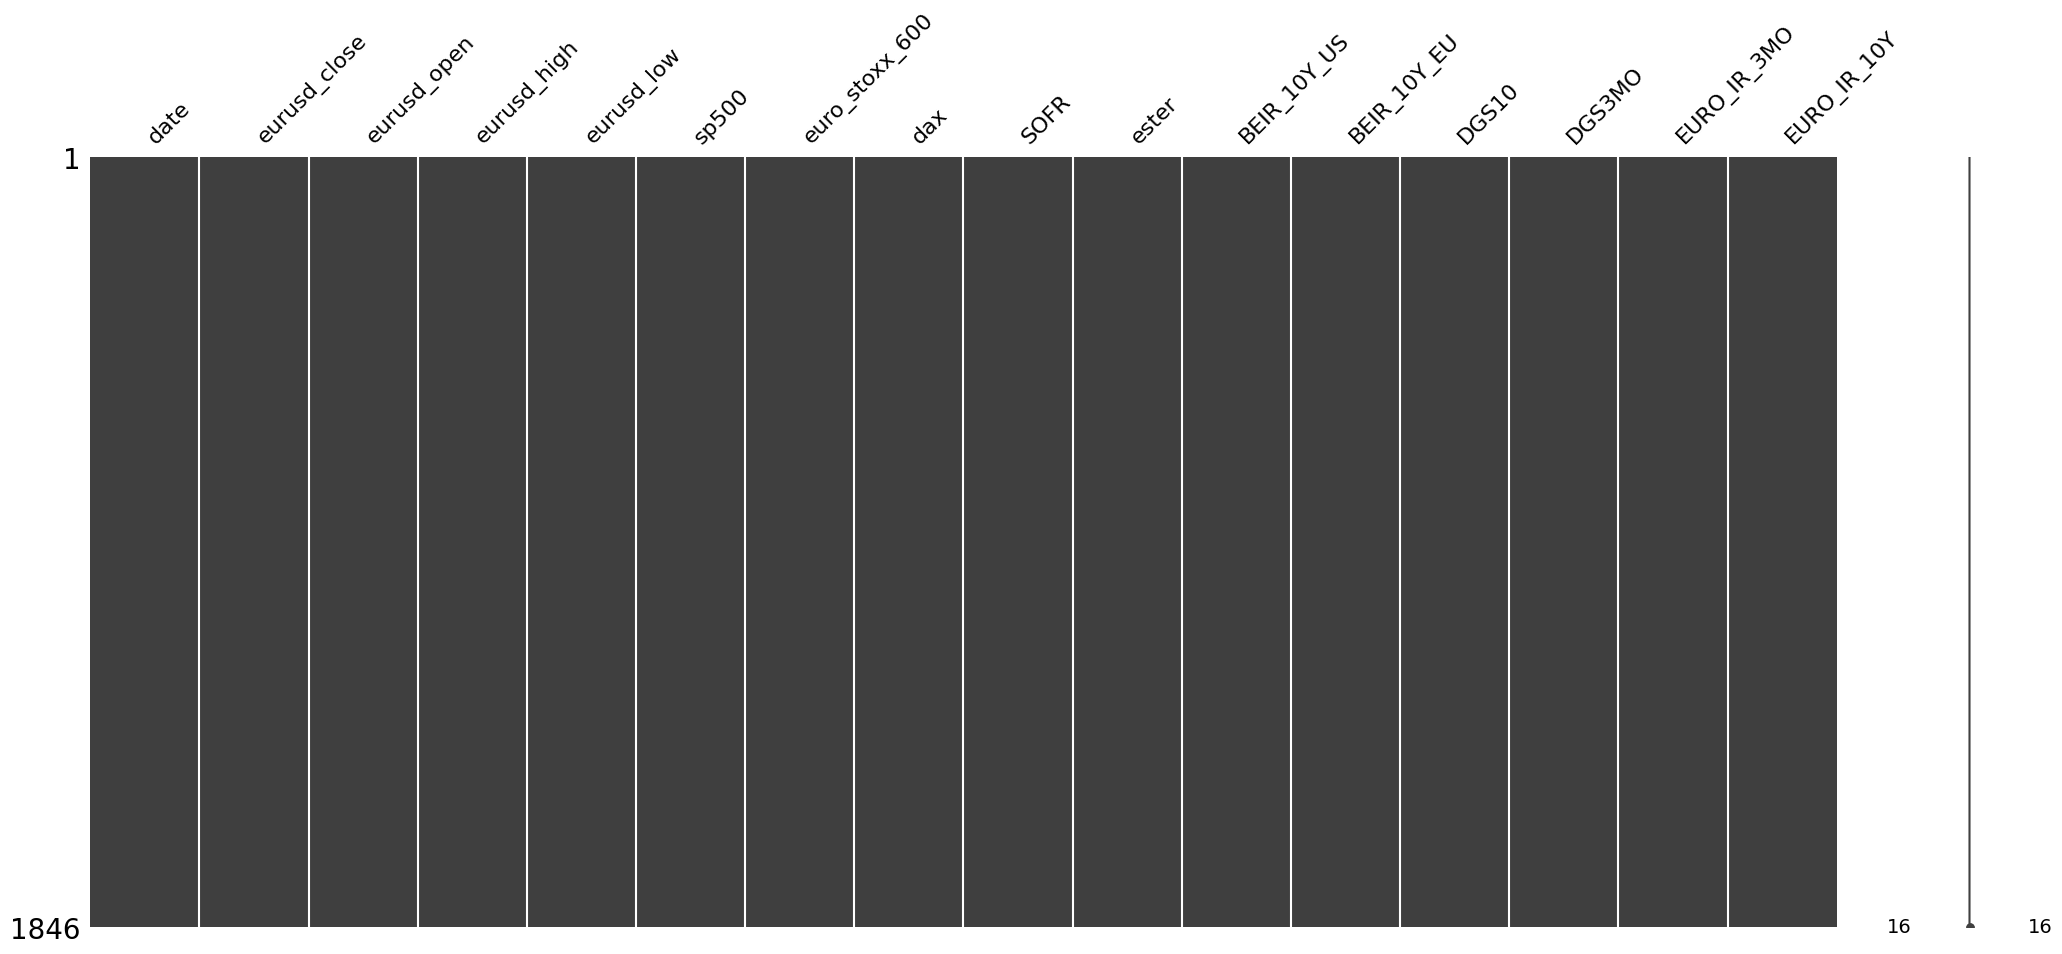

In [5]:
msno.matrix(df)

In [6]:
df['return_eurousd'] = np.log(df['eurusd_close'] / df['eurusd_close'].shift(1))

In [7]:
df = df.dropna()

In [8]:
returns = df['return_eurousd']

# Calculate historical volatility
hv = calculate_historical_volatility(returns, window=30)
df['historical_volatility'] = hv

df.head()

,date,eurusd_close,eurusd_open,eurusd_high,eurusd_low,sp500,euro_stoxx_600,dax,SOFR,ester,BEIR_10Y_US,BEIR_10Y_EU,DGS10,DGS3MO,EURO_IR_3MO,EURO_IR_10Y,return_eurousd,historical_volatility
1,2018-04-04,1.227853,1.227943,1.231057,1.225761,2644.689941,367.329987,11957.900391,1.74,-0.454,2.08,1.511,2.79,1.71,-0.664585,0.547333,-0.001155,NaN
2,2018-04-05,1.228682,1.228788,1.229105,1.221941,2662.840088,376.130005,12305.190430,1.75,-0.453,2.08,1.509,2.83,1.72,-0.659658,0.570174,0.000676,NaN
3,2018-04-06,1.225160,1.225100,1.228003,1.221807,2604.469971,374.820007,12241.269531,1.75,-0.453,2.07,1.510,2.77,1.73,-0.664742,0.559924,-0.002871,NaN
4,2018-04-09,1.227144,1.227144,1.233046,1.226257,2613.159912,375.299988,12261.750000,1.75,-0.453,2.07,1.508,2.78,1.76,-0.657340,0.561172,0.001619,NaN
5,2018-04-10,1.232240,1.232225,1.237777,1.230376,2656.870117,378.420013,12397.320312,1.75,-0.453,2.08,1.518,2.80,1.74,-0.652443,0.564737,0.004144,NaN


<Axes: >

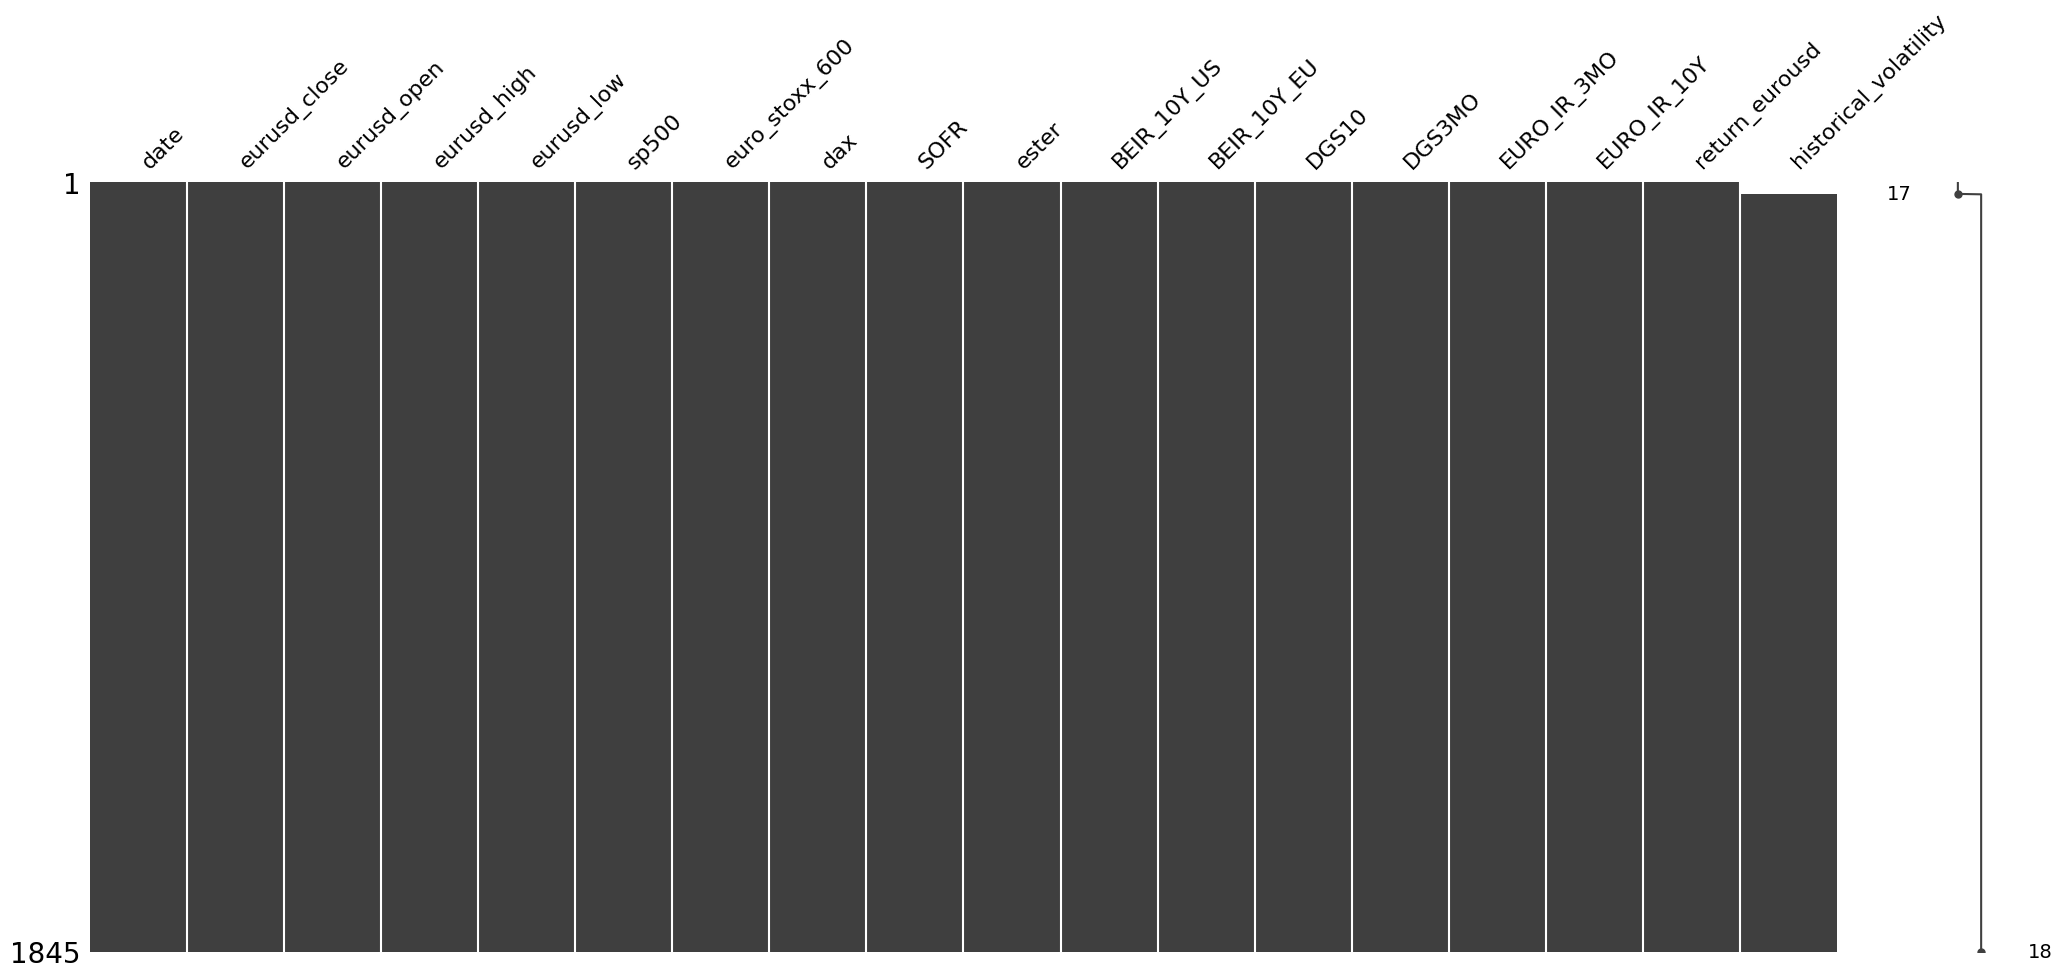

In [9]:
msno.matrix(df)

In [10]:
df = df.dropna()

In [11]:
# Test stationarity of the returns series
test_stationarity(df['return_eurousd'])

ADF Statistic: -41.65479966484673
p-value: 0.0


In [12]:
# Split après avoir calculé la volatilité
split_point = len(df)-256

train_returns = df['return_eurousd'].iloc[:split_point]
test_returns = df['return_eurousd'].iloc[split_point:]
test_hv = df['historical_volatility'].iloc[split_point:]
test_dates = df['date'].iloc[split_point:]  # ← Ajoutez cette ligne

print(f"Split point index: {split_point}")
print(f"Date de début du test: {test_dates.iloc[0]}")
print(f"Size of the training set: {len(train_returns)}")
print(f"Size of the test set: {len(test_returns)}")


Split point index: 1560
Date de début du test: 2024-05-08 00:00:00
Size of the training set: 1560
Size of the test set: 256


In [13]:
train_returns.head()

30   -0.001755
31   -0.009287
32   -0.000331
33   -0.001842
34   -0.002427
Name: return_eurousd, dtype: float64

In [14]:
# Find the best GARCH model
model_metrics = {}
for model_type in ['Garch', 'EGARCH', 'GJR-GARCH']:
    for dist in ['Normal', 'StudentsT', 'ged']:
        try:
            result, _ = fit_model(train_returns, model_type=model_type, distribution=dist)
            model_metrics[(model_type, dist)] = {
                'AIC': result.aic,
                'BIC': result.bic,
                'Log-Likelihood': result.loglikelihood
            }
        except:
            print(f"Erreur avec {model_type}, {dist}")

Best model according to AIC: ('Garch', 'StudentsT')
Residuals normality test: stat=61.883158439379855, p-value=3.649579962578478e-14


<Figure size 1200x600 with 0 Axes>

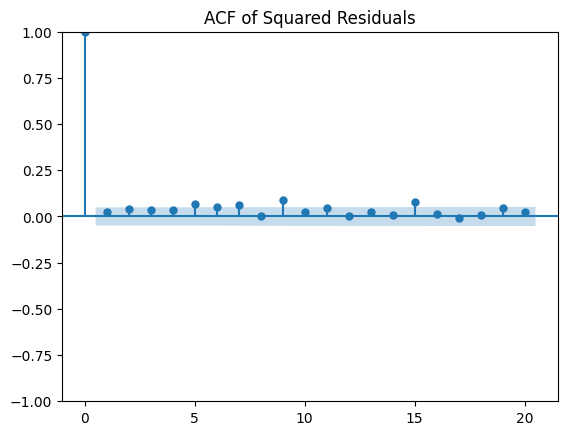

In [15]:
model_comparison = pd.DataFrame(model_metrics).T
best_model = model_comparison['AIC'].idxmin()
print(f"Best model according to AIC: {best_model}")

# Analyze the best model
best_result, _ = fit_model(train_returns, model_type=best_model[0], distribution=best_model[1])
residuals = best_result.resid / np.sqrt(best_result.conditional_volatility)


k2, p = stats.normaltest(residuals)
print(f"Residuals normality test: stat={k2}, p-value={p}")

# Residuals autocorrelation
plt.figure(figsize=(12, 6))
plot_acf(residuals**2, lags=20)
plt.title('ACF of Squared Residuals')
plt.show()

<Figure size 1200x600 with 0 Axes>

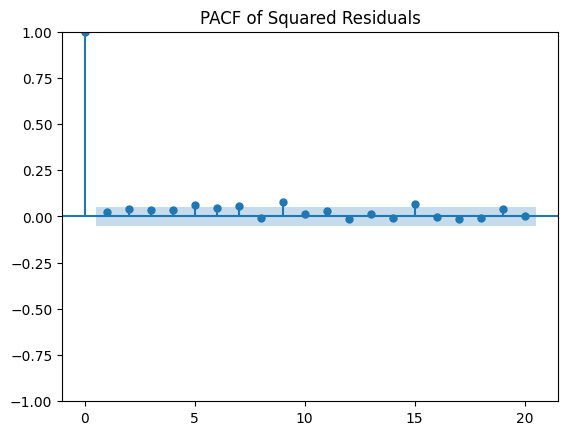

In [16]:
plt.figure(figsize=(12, 6))
plot_pacf(residuals**2, lags=20)
plt.title('PACF of Squared Residuals')
plt.show()

In [17]:
# Function to find the best GARCH model order based on AIC and BIC
results_df, best_aic_order, best_bic_order = find_best_order(train_returns, max_p=3, max_q=3)

Best order by AIC: GARCH(1,1)
Best order by BIC: GARCH(1,1)


In [18]:
# Fit the model only on training data
model_result, train_volatility = fit_model(train_returns, model_type="GARCH", distribution='StudentsT')

# Vos prédictions GARCH (inchangées)
test_volatility = []
for i in range(len(test_returns)):
    current_data = pd.concat([train_returns, test_returns.iloc[:i]])
    temp_model, _ = fit_model(current_data, model_type="GARCH", distribution='StudentsT')
    forecast = temp_model.forecast(horizon=1)
    vol = np.sqrt(forecast.variance.iloc[0, 0]) * np.sqrt(252) / 100
    test_volatility.append(vol)

test_volatility_series = pd.Series(test_volatility, index=test_returns.index)


In [19]:
# Évaluation plus simple
test_mse = mean_squared_error(test_hv, test_volatility_series)
test_mae = mean_absolute_error(test_hv, test_volatility_series)



# Création d'un DataFrame pour visualiser les métriques
metrics_df = pd.DataFrame({
    'Metric': ['MSE', 'MAE'],
    'Value': [test_mse, test_mae]
})

print("\nEvaluation metrics on the test:")
print(f"MSE: {test_mse:.6f}")
print(f"MAE: {test_mae:.6f}")



Evaluation metrics on the test:
MSE: 0.000040
MAE: 0.004853


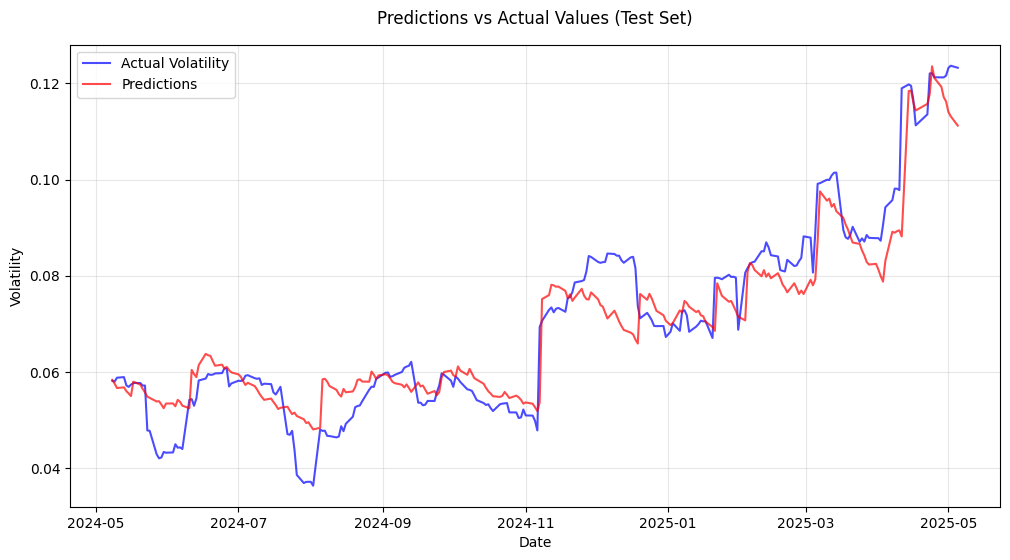

In [20]:
# Plot avec les bonnes dates
plot_predictions_vs_actual(
    test_hv, 
    test_volatility_series, 
    dates=test_dates  # ← Utilisez test_dates au lieu de df["date"].iloc[split_point:]
)